In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
conn = sqlite3.connect('uniref90-10pm.db')
c = conn.cursor()

In [3]:
# get distribution of sequence lengths
c.execute('SELECT LENGTH(sequence) AS sequence_length FROM uniref90 where embedding is not null')
lengths = np.array(c.fetchall())

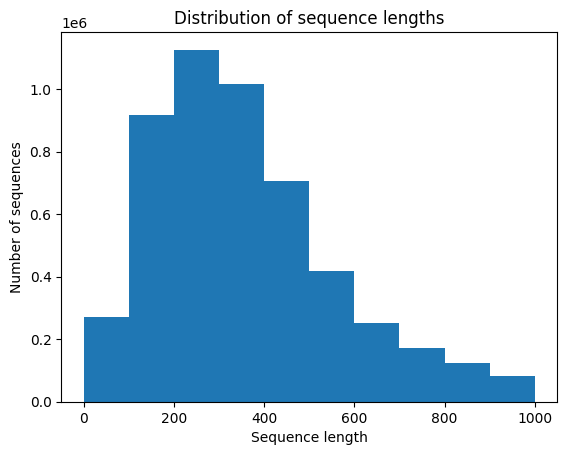

In [4]:
# plot histogram
plt.hist(lengths, bins=10, range=(0, 1000))
plt.xlabel('Sequence length')
plt.ylabel('Number of sequences')
plt.title('Distribution of sequence lengths')
plt.show()

In [13]:
# print bin percentages
hist, bins = np.histogram(lengths, bins=10, range=(0, 1000))

# convert to percentages of total that is under 1000
hist = hist / sum(hist) * 100
for i in range(len(hist)):
    print(f'{bins[i]}-{bins[i+1]}: {hist[i]:.2f}%')

# multiply these percentages by the 1000 to see how many of each length we would have to randomly generate
# to get the same distribution
print('Number of sequences to generate to get the same distribution:')
# convert to integer number of sequences
hist = hist / 100 * 1000
for i in range(len(hist)):
    print(f'{bins[i]}-{bins[i+1]}: {int(hist[i])}')

print('Total:', int(sum(hist)))


0.0-100.0: 5.32%
100.0-200.0: 18.01%
200.0-300.0: 22.15%
300.0-400.0: 19.99%
400.0-500.0: 13.92%
500.0-600.0: 8.20%
600.0-700.0: 4.93%
700.0-800.0: 3.41%
800.0-900.0: 2.44%
900.0-1000.0: 1.62%
Number of sequences to generate to get the same distribution:
0.0-100.0: 53
100.0-200.0: 180
200.0-300.0: 221
300.0-400.0: 199
400.0-500.0: 139
500.0-600.0: 82
600.0-700.0: 49
700.0-800.0: 34
800.0-900.0: 24
900.0-1000.0: 16
Total: 999


In [6]:
# print summary statistics
print('Summary statistics for sequence lengths:')
print(pd.DataFrame(lengths).describe())

Summary statistics for sequence lengths:
                  0
count  5.168858e+06
mean   3.692537e+02
std    2.250350e+02
min    1.100000e+01
25%    2.100000e+02
50%    3.230000e+02
75%    4.730000e+02
max    1.074600e+04


In [7]:
conn.close()

In [8]:
print(max(lengths))

[10746]


In [28]:
# get index of longest sequence, 4499
c.execute('SELECT name, sequence FROM uniref90 WHERE LENGTH(sequence) = 4499')

In [29]:
print('Longest sequence:')
print(c.fetchone())

Longest sequence:
('E9PWP7', 'MSTRRWVRQTAALCLLAFILHSLPRHIAAENGTTESGSVWDGGGNSTQDDSQETQFRTVLKTKTTDGENSEAWPRQEYQQRSSSPSTTKAEVTTTADVTTTADVTTTAEITTTSDVTTTAEITNTDDVTTTGEVTTTADVTTTSDVPTTSEVTSTDDVITTAEVTTTAEMTPTDDVTTTSEVTTTGDVTTTGDVTITGDLTTTADVTTKADFTTTDDVTTTADGSTTADLTTTAKVTTTDDVTTTGEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTIAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETTTADITTTADLTTTAEITTTDDVTTTVEITTTSDVTTTTEITTTDIVTTTGEVTTTADVTTASDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTGEVTTTADVTTTSDVTTTSEETTTADVTTTSDVTTTAEITTTDDITSTADVTTTADVTTTSDVPTTSEETTTADVTTTSDVTTTAEITTTDDITSTADVTTTADVTTTSDVTTTTEENPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTDEDTTTADVTTTSDVTTTSEETPTADITTTADLTTTADVTTTSDVTTTSEETTTADVTTTSDVTTTAEITTTDDITSTADVTTTTNVTTTSDVPTTSEVTSTDDVITTTEVTTTAEIIPTDDVTTTSEVTTTGDVTTTGDVTMTGDLTTTADVTTTADLTTTDEVTTTADGSTTADLTTTAEVTTTDDVTTTVQITTTSEITTTSDVTTTAEITTTDNVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLNTTAEVTTTEDVTTTVEITTTSEITTTSDITTTAEITTTDIVTTTGEVTTTADVTTTNDVTTTSEETP

In [3]:
conn = sqlite3.connect('uniref90-10pm.db')
c = conn.cursor()

In [4]:
# check embedding
c.execute('SELECT embedding FROM uniref90 LIMIT 1000')
embedding = c.fetchall()


In [5]:
# calculate euclidean distance and cosine similarity between first two sequences
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import tqdm
# get pairwise distances of embeddings
distances = np.zeros((1000, 1000))
similarities = np.zeros((1000, 1000))

for i in tqdm.tqdm(range(1000), desc='Calculating distances', unit='sequence', total=1000):
    for j in range(1000):
        e1 = np.frombuffer(embedding[i][0], dtype=np.float16)
        e2 = np.frombuffer(embedding[j][0], dtype=np.float16)
        distances[i, j] = euclidean(e1, e2)
        similarities[i, j] = cosine_similarity([e1], [e2])[0, 0]

Calculating distances: 100%|██████████| 1000/1000 [05:35<00:00,  2.98sequence/s]


Summary statistics for Euclidean distances:
                   0
count  499500.000000
mean        1.621331
std         0.318033
min         0.066711
25%         1.420898
50%         1.597656
75%         1.773438
max         4.113281
Summary statistics for cosine similarities:
                   0
count  499500.000000
mean        0.326207
std         0.113527
min        -0.052748
25%         0.245836
50%         0.312912
75%         0.393237
max         0.998714


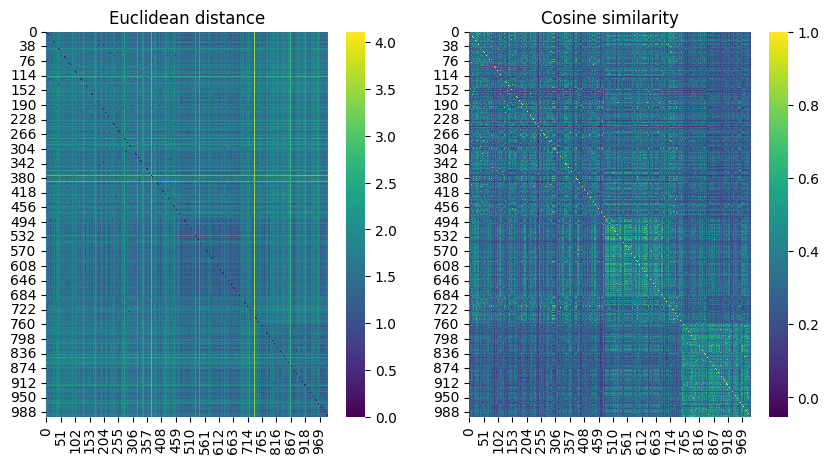

In [6]:
# plot distance matrix and similarity matrix
import seaborn as sns
# print summary statistics for distances and similarities, for the upper triangle flattened to one array
print('Summary statistics for Euclidean distances:')
print(pd.DataFrame(distances[np.triu_indices(1000, 1)]).describe())
print('Summary statistics for cosine similarities:')
print(pd.DataFrame(similarities[np.triu_indices(1000, 1)]).describe())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(distances, cmap='viridis')
plt.title('Euclidean distance')
plt.subplot(1, 2, 2)
sns.heatmap(similarities, cmap='viridis')   
plt.title('Cosine similarity')
plt.show()

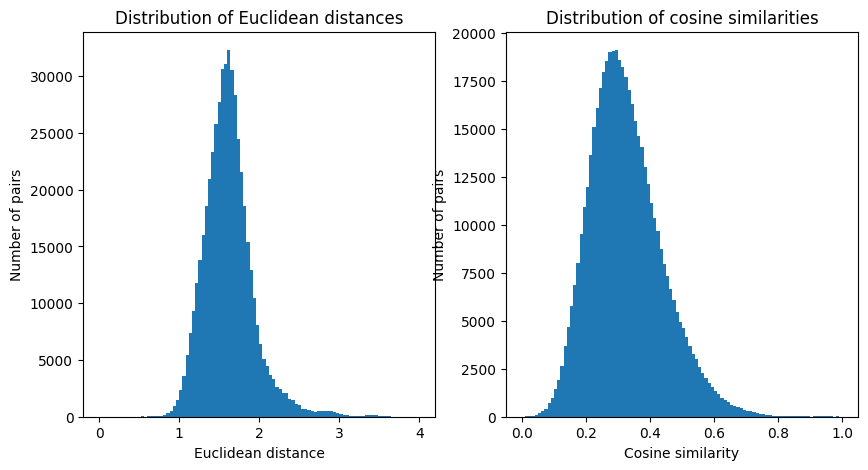

In [9]:
import matplotlib.pyplot as plt
#plot histograms of distances and similarities

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(distances[np.triu_indices(1000, 1)], bins=100, range=(0, 4))
plt.xlabel('Euclidean distance')
plt.ylabel('Number of pairs')
plt.title('Distribution of Euclidean distances')
plt.subplot(1, 2, 2)
plt.hist(similarities[np.triu_indices(1000, 1)], bins=100, range=(0, 1))
plt.xlabel('Cosine similarity')
plt.ylabel('Number of pairs')
plt.title('Distribution of cosine similarities')
plt.show()

In [36]:
# close
conn.close()